# Mini-projet n°1 – Chats ou Chiens ?

In [1]:
#Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout,  GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, clone_model, Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 


2026-01-06 13:55:17.646343: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-06 13:55:24.830779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-06 13:56:00.157825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df = pd.read_csv(
    "./oxford-iiit-pet/annotations/list.txt",
    sep=r"\s+",                                         
    comment="#",                                        
    header=None,                                        
    names=["Image", "CLASS_ID", "SPECIES", "BREED_ID"]
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7349 entries, 0 to 7348
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     7349 non-null   object
 1   CLASS_ID  7349 non-null   int64 
 2   SPECIES   7349 non-null   int64 
 3   BREED_ID  7349 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 229.8+ KB


Le jeu de données est composé de 7349 individus.
Les variables sont les suivantes :
- Image : au format .jpg ;
- CLASS\_ID (race) : 37 races différentes ;
- SPECIES : chat ou chien (1 ou 2 selon l'espèce) ;
- BREED\_ID : identifiant de la race parmi l'espèce concernée.

Afin de rendre les données plus lisibles, nous rajoutons deux variables non numériques précisant les noms de l'espèce (SPECIES\_NAME) et de la race (BREED\_NAME) de chaque individu.

In [3]:
df["BREED_NAME"] = df["Image"].str.rsplit("_", n=1).str[0]           # Nom de la race
df["SPECIES_NAME"] = df["SPECIES"].map({1: "Cat", 2: "Dog"})         # Chat ou chien
df["Image"] = df["Image"].apply(lambda x: f"{x}.jpg")

print(df.sample(n=3, random_state=42))

                      Image  CLASS_ID  SPECIES  BREED_ID      BREED_NAME  \
2755       keeshond_164.jpg        19        2        13        keeshond   
2966   newfoundland_178.jpg        23        2        16    newfoundland   
5186  great_pyrenees_31.jpg        16        2        10  great_pyrenees   

     SPECIES_NAME  
2755          Dog  
2966          Dog  
5186          Dog  


### Étude de la répartition par race et par type


SPECIES_NAME
Dog    4978
Cat    2371
Name: count, dtype: int64

Pourcentages:
SPECIES_NAME
Dog    67.737107
Cat    32.262893
Name: count, dtype: float64


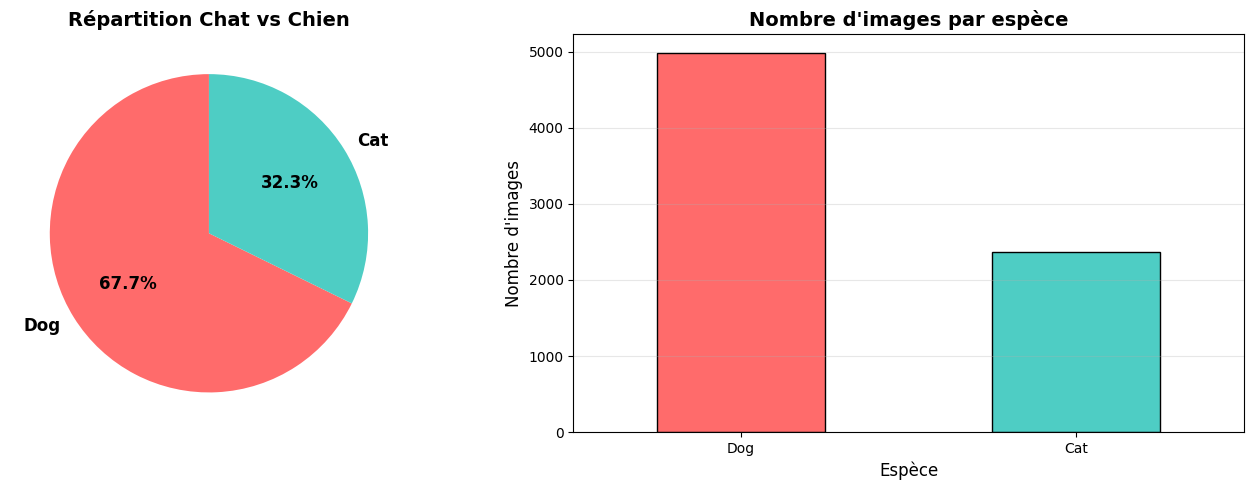

In [17]:
species_counts = df["SPECIES_NAME"].value_counts()
print(f"\n{species_counts}")
print(f"\nPourcentages:")
print(species_counts / len(df) * 100)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#FF6B6B', '#4ECDC4']
axes[0].pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
axes[0].set_title('Répartition Chat vs Chien', fontsize=14, weight='bold')

# Bar chart
species_counts.plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title('Nombre d\'images par espèce', fontsize=14, weight='bold')
axes[1].set_xlabel('Espèce', fontsize=12)
axes[1].set_ylabel('Nombre d\'images', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Nombre total de races: 37

Top 10 races les plus représentées:
BREED_NAME
american_bulldog             200
basset_hound                 200
american_pit_bull_terrier    200
beagle                       200
Bengal                       200
yorkshire_terrier            200
Birman                       200
chihuahua                    200
British_Shorthair            200
havanese                     200
Name: count, dtype: int64

Top 10 races les moins représentées:
BREED_NAME
Siamese                       199
boxer                         199
keeshond                      199
scottish_terrier              199
Abyssinian                    198
english_cocker_spaniel        196
newfoundland                  196
Egyptian_Mau                  190
staffordshire_bull_terrier    189
Bombay                        184
Name: count, dtype: int64

📈 Statistiques:
Moyenne d'images par race: 198.62
Médiane: 200.00
Écart-type: 3.52
Min: 184 | Max: 200


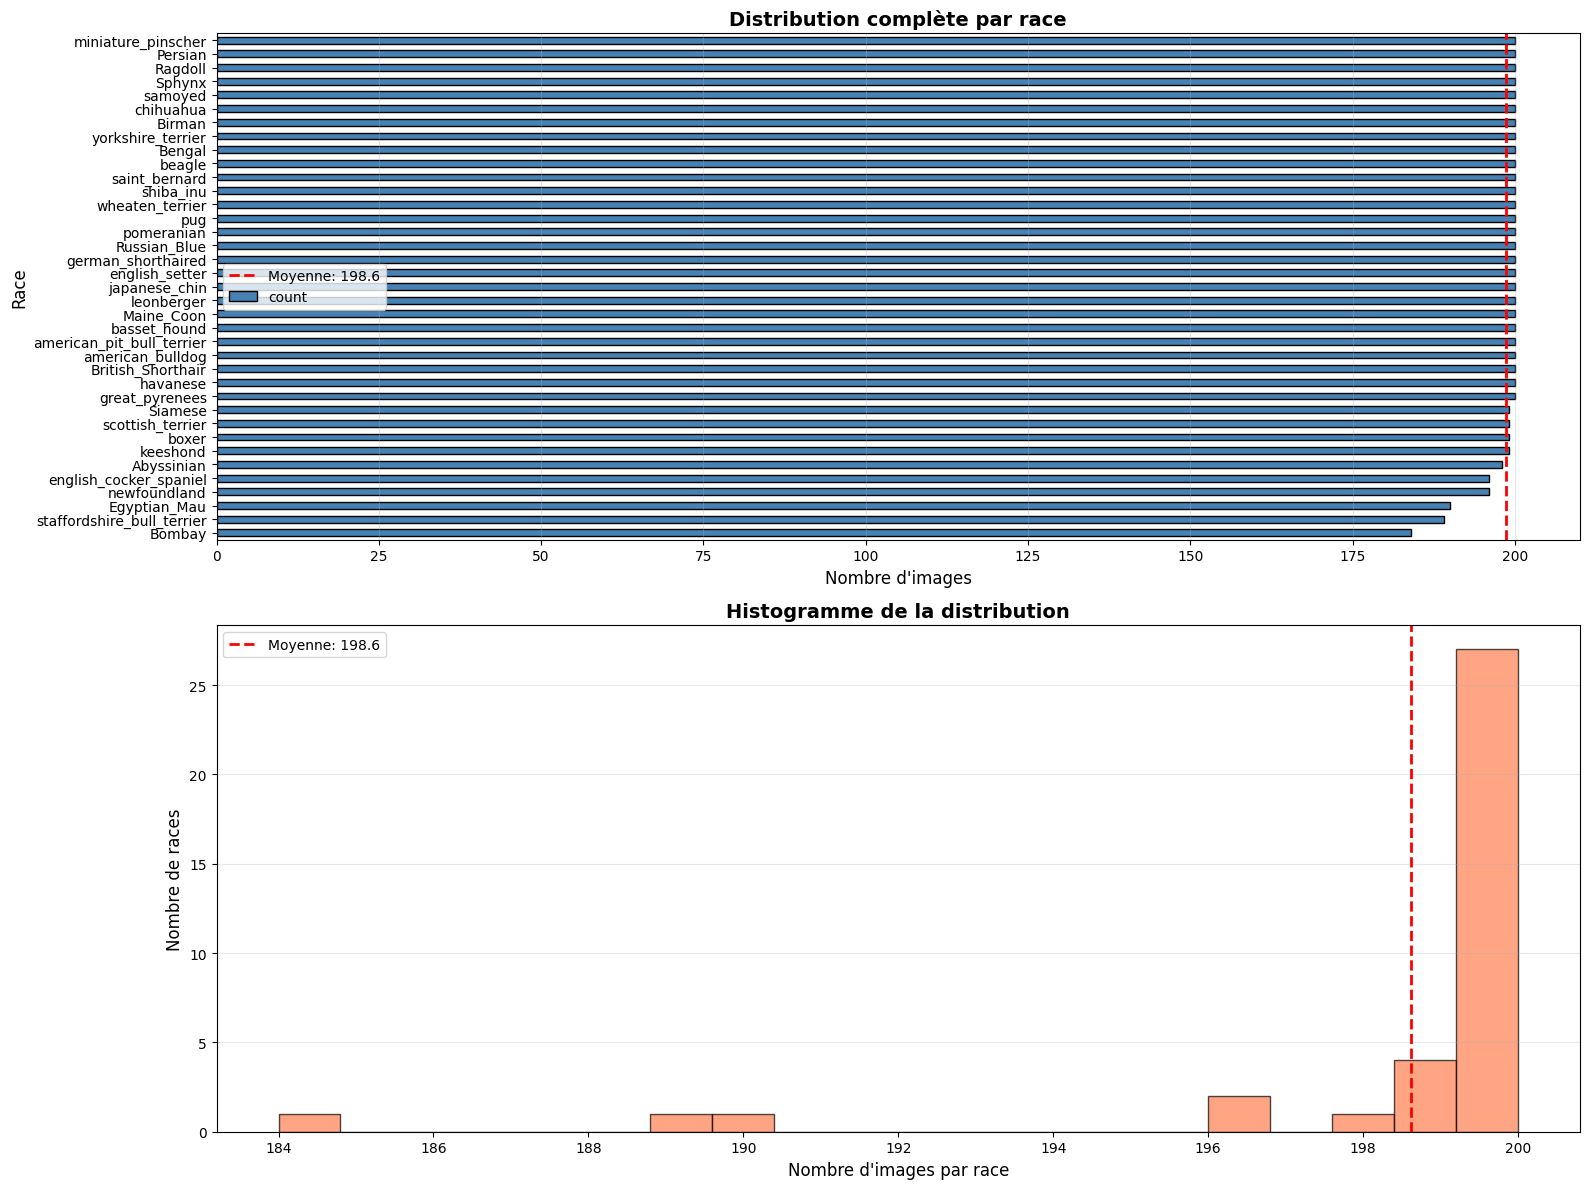

In [18]:
breed_counts = df["BREED_NAME"].value_counts().sort_values(ascending=False)
print(f"\nNombre total de races: {len(breed_counts)}")
print(f"\nTop 10 races les plus représentées:")
print(breed_counts.head(10))
print(f"\nTop 10 races les moins représentées:")
print(breed_counts.tail(10))

# Statistiques
print(f"\n📈 Statistiques:")
print(f"Moyenne d'images par race: {breed_counts.mean():.2f}")
print(f"Médiane: {breed_counts.median():.2f}")
print(f"Écart-type: {breed_counts.std():.2f}")
print(f"Min: {breed_counts.min()} | Max: {breed_counts.max()}")

# Visualisation complète
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Toutes les races
breed_counts.sort_values().plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Distribution complète par race', fontsize=14, weight='bold')
axes[0].set_xlabel('Nombre d\'images', fontsize=12)
axes[0].set_ylabel('Race', fontsize=12)
axes[0].axvline(x=breed_counts.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Moyenne: {breed_counts.mean():.1f}')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Histogramme de la distribution
axes[1].hist(breed_counts, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Histogramme de la distribution', fontsize=14, weight='bold')
axes[1].set_xlabel('Nombre d\'images par race', fontsize=12)
axes[1].set_ylabel('Nombre de races', fontsize=12)
axes[1].axvline(x=breed_counts.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Moyenne: {breed_counts.mean():.1f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Le nombre d'individus est environ le même pour chaque race (200). Les données semblent a priori équilibré,  même si certaines races (Bombay, chat) n'ont pas autant d'individus que les autres.
On peut conclure cette sous-partie en avançant que les données sont suffisament bien réparties selon les espèces et les races. Il y a une légère sur-représentations des chiens, et les races sont légèrement déséquilibrés, mais cela ne devrait pas être impactant pour la suite.

### Déséquilibre des classes

Classes équilibrées (≥195 images): 34
Classes légèrement déséquilibrées (180-194 images): 3
Classes déséquilibrées (<180 images): 0


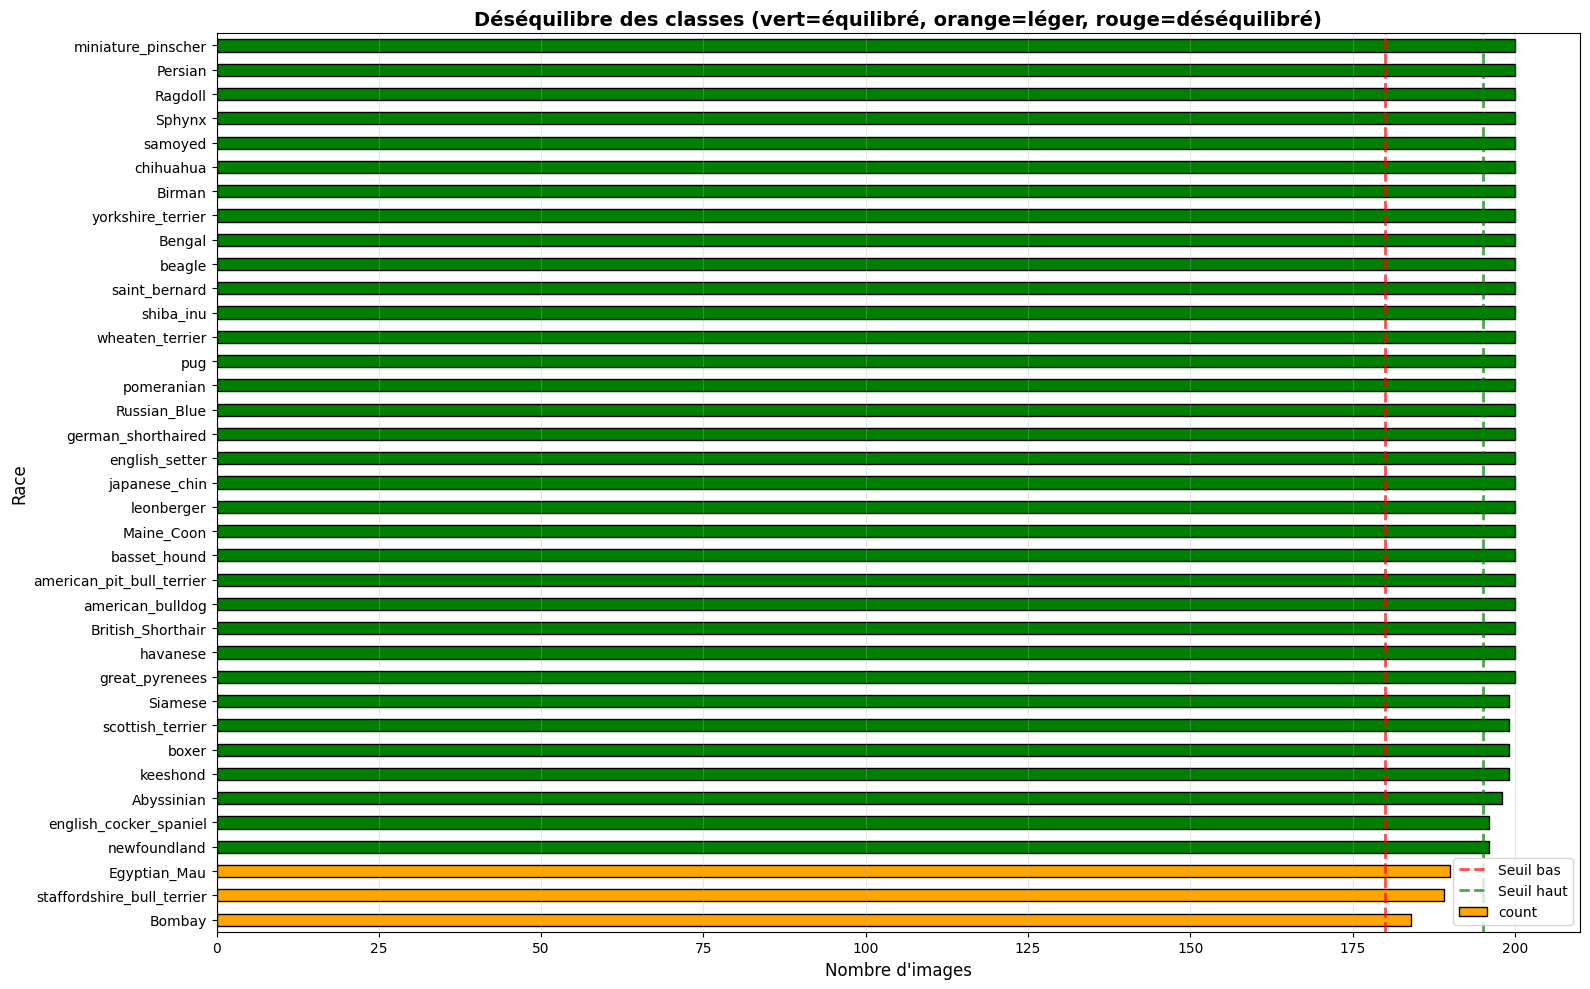

In [19]:
# Catégorisation
threshold_low = 180
threshold_high = 195

balanced = breed_counts[breed_counts >= threshold_high]
slightly_imbalanced = breed_counts[(breed_counts >= threshold_low) & (breed_counts < threshold_high)]
imbalanced = breed_counts[breed_counts < threshold_low]

print(f"Classes équilibrées (≥{threshold_high} images): {len(balanced)}")
print(f"Classes légèrement déséquilibrées ({threshold_low}-{threshold_high-1} images): {len(slightly_imbalanced)}")
print(f"Classes déséquilibrées (<{threshold_low} images): {len(imbalanced)}")

if len(imbalanced) > 0:
    print(f" Races les plus déséquilibrées:")
    print(imbalanced)

# Visualisation avec code couleur
fig, ax = plt.subplots(figsize=(16, 10))
colors_list = ['green' if x >= threshold_high else 'orange' if x >= threshold_low else 'red' 
               for x in breed_counts.sort_values()]
breed_counts.sort_values().plot(kind='barh', ax=ax, color=colors_list, edgecolor='black')
ax.set_title('Déséquilibre des classes (vert=équilibré, orange=léger, rouge=déséquilibré)', 
             fontsize=14, weight='bold')
ax.set_xlabel('Nombre d\'images', fontsize=12)
ax.set_ylabel('Race', fontsize=12)
ax.axvline(x=threshold_low, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Seuil bas')
ax.axvline(x=threshold_high, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Seuil haut')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### Répartition par race et par espèce


Nombre de races de chats: 12
Nombre de races de chiens: 25

Races de chats: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx']

Races de chiens: ['american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


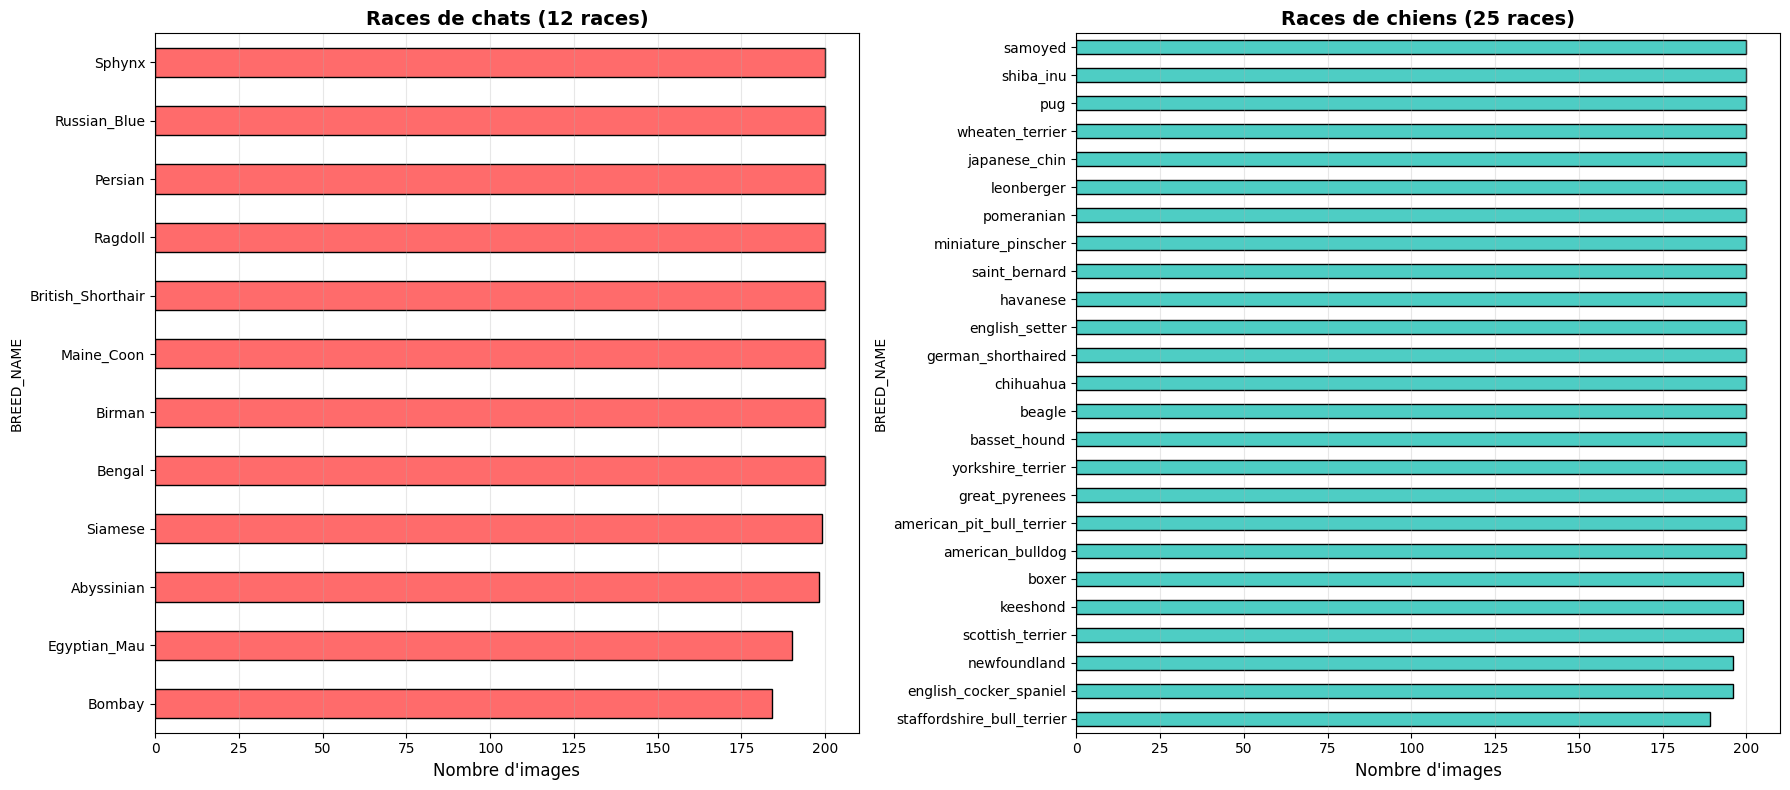

In [20]:
breed_species = df.groupby(['BREED_NAME', 'SPECIES_NAME']).size().reset_index(name='count')
cats_breeds = breed_species[breed_species['SPECIES_NAME'] == 'Cat']['BREED_NAME'].unique()
dogs_breeds = breed_species[breed_species['SPECIES_NAME'] == 'Dog']['BREED_NAME'].unique()

print(f"\nNombre de races de chats: {len(cats_breeds)}")
print(f"Nombre de races de chiens: {len(dogs_breeds)}")

print(f"\nRaces de chats: {sorted(cats_breeds)}")
print(f"\nRaces de chiens: {sorted(dogs_breeds)}")

# Visualisation séparée
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

cats_data = df[df['SPECIES_NAME'] == 'Cat']['BREED_NAME'].value_counts().sort_values()
dogs_data = df[df['SPECIES_NAME'] == 'Dog']['BREED_NAME'].value_counts().sort_values()

cats_data.plot(kind='barh', ax=axes[0], color='#FF6B6B', edgecolor='black')
axes[0].set_title(f'Races de chats ({len(cats_breeds)} races)', fontsize=14, weight='bold')
axes[0].set_xlabel('Nombre d\'images', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

dogs_data.plot(kind='barh', ax=axes[1], color='#4ECDC4', edgecolor='black')
axes[1].set_title(f'Races de chiens ({len(dogs_breeds)} races)', fontsize=14, weight='bold')
axes[1].set_xlabel('Nombre d\'images', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### Cohérence des masques de segmentation


Vérification en cours...
 Résultats (sur 100 images):
 Images présentes: 100/100 (100.0%)
 Masques présents: 100/100 (100.0%)
 Dimensions concordantes: 100/100 (100.0%)
 Masques valides (valeurs 1,2,3): 100/100 (100.0%)
  Visualisation d'exemples...
Visualisation des exemples terminée


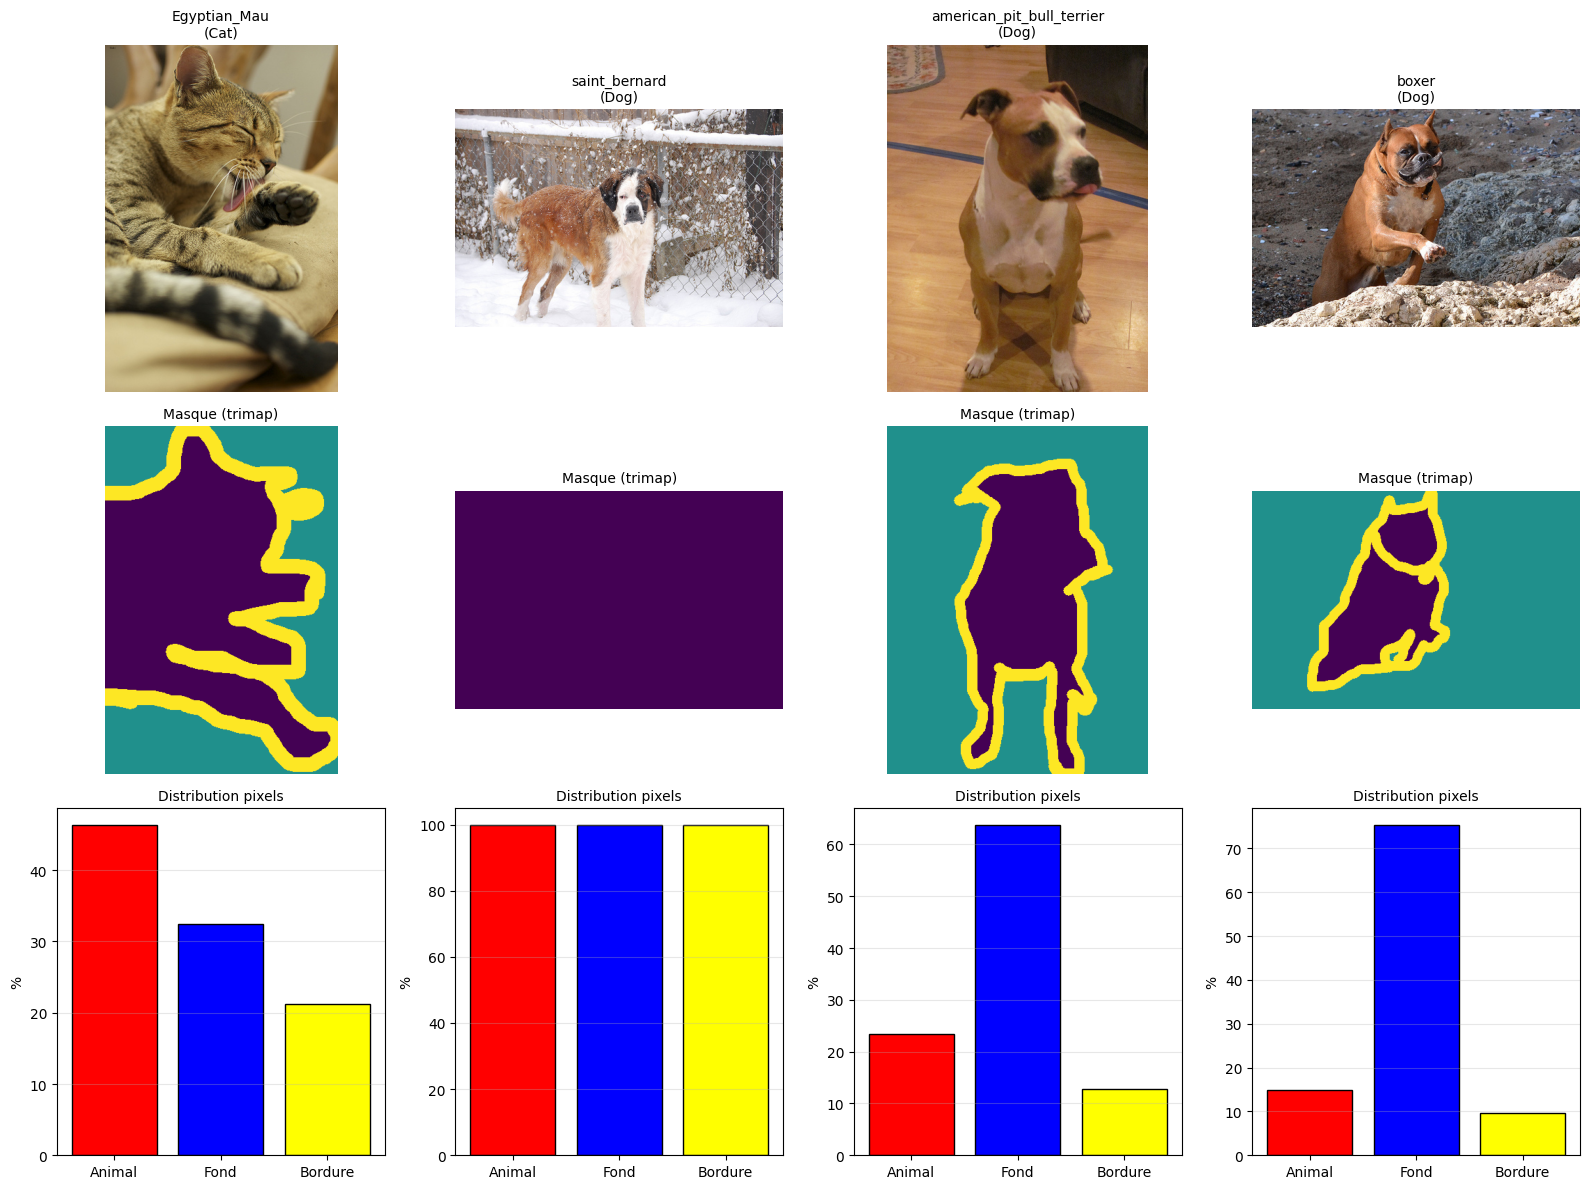

In [22]:
images_dir = "./oxford-iiit-pet/images"
masks_dir = "./oxford-iiit-pet/annotations/trimaps"

# Vérifier l'existence des fichiers
images_exist = []
masks_exist = []
dimensions_match = []
mask_quality = []

print("\nVérification en cours...")
sample_size = min(100, len(df))  # Échantillon pour test rapide

for idx, row in df.head(sample_size).iterrows():
    img_name = row['Image']
    mask_name = img_name.replace('.jpg', '.png')
    
    img_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)
    
    img_exists = os.path.exists(img_path)
    mask_exists = os.path.exists(mask_path)
    
    images_exist.append(img_exists)
    masks_exist.append(mask_exists)
    
    if img_exists and mask_exists:
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        dimensions_match.append(img.size == mask.size)
        
        # Vérifier valeurs du masque
        mask_array = np.array(mask)
        unique_vals = np.unique(mask_array)
        valid_mask = all(val in [1, 2, 3] for val in unique_vals)
        mask_quality.append(valid_mask)
    else:
        dimensions_match.append(False)
        mask_quality.append(False)

print(f" Résultats (sur {sample_size} images):")
print(f" Images présentes: {sum(images_exist)}/{sample_size} ({sum(images_exist)/sample_size*100:.1f}%)")
print(f" Masques présents: {sum(masks_exist)}/{sample_size} ({sum(masks_exist)/sample_size*100:.1f}%)")
print(f" Dimensions concordantes: {sum(dimensions_match)}/{sample_size} ({sum(dimensions_match)/sample_size*100:.1f}%)")
print(f" Masques valides (valeurs 1,2,3): {sum(mask_quality)}/{sample_size} ({sum(mask_quality)/sample_size*100:.1f}%)")

# Visualiser des exemples
print("  Visualisation d'exemples...")
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_indices = rd.sample(range(len(df)), 4)

for i, idx in enumerate(sample_indices):
    row = df.iloc[idx]
    img_name = row['Image']
    mask_name = img_name.replace('.jpg', '.png')
    
    img_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)
    
    if os.path.exists(img_path) and os.path.exists(mask_path):
        # Image originale
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"{row['BREED_NAME']}\n({row['SPECIES_NAME']})", fontsize=10)
        axes[0, i].axis('off')
        
        # Masque
        mask = np.array(Image.open(mask_path))
        axes[1, i].imshow(mask, cmap='viridis')
        axes[1, i].set_title('Masque (trimap)', fontsize=10)
        axes[1, i].axis('off')
        
        # Statistiques du masque
        unique, counts = np.unique(mask, return_counts=True)
        props = counts / mask.size * 100
        axes[2, i].bar(['Animal', 'Fond', 'Bordure'], props, 
                      color=['red', 'blue', 'yellow'], edgecolor='black')
        axes[2, i].set_ylabel('%')
        axes[2, i].set_title('Distribution pixels', fontsize=10)
        axes[2, i].grid(axis='y', alpha=0.3)

plt.tight_layout()
print("Visualisation des exemples terminée")
plt.show()

ANALYSE À FAIRE ==> LA NEIGE COMPLIQUÉ A VISUALISER MASQUE PAS FOU

### Classification binaire

en gros ici on veut savoir si on arrive bien a retrouver les chats et les chiens 

In [6]:

# --- Configuration des chemins (A ajuster selon votre dossier) ---
base_path = "./oxford-iiit-pet/"
img_dir = os.path.join(base_path, "images/")
mask_dir = os.path.join(base_path, "annotations/trimaps/")

# --- Ajout de la colonne des masques ---
# Les masques portent le même nom que l'image, mais en .png
# Votre colonne 'Image' contient déjà l'extension .jpg, on doit la remplacer
df['mask_filename'] = df['Image'].str.replace('.jpg', '.png')

# Vérification que les fichiers existent (optionnel mais recommandé)
# df = df[df['Image'].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))]

# --- Division du Dataset (Train / Val / Test) ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['SPECIES_NAME'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['SPECIES_NAME'])

print(f"Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")

Train: 4703 | Validation: 1176 | Test: 1470


In [7]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 4703 validated image filenames belonging to 2 classes.
Found 1176 validated image filenames belonging to 2 classes.
Found 1470 validated image filenames belonging to 2 classes.


Ce code configure le pipeline de préparation des données pour la classification binaire (Chats vs Chiens). Il définit d'abord les hyperparamètres structurels, fixant la résolution des images à 150×150 pixels et la taille des lots (batch_size) à 20, une valeur choisie pour diviser exactement le nombre total d'échantillons. Trois instances d'ImageDataGenerator sont ensuite créées pour les ensembles d'entraînement, de validation et de test, appliquant uniquement une normalisation des pixels (rescale=1./255) pour ramener leurs valeurs dans l'intervalle [0,1]. La méthode flow_from_dataframe est utilisée pour générer les flux de données en associant les fichiers images du répertoire img_dir (colonne 'Image') à leurs étiquettes cibles (colonne 'SPECIES_NAME'). Enfin, le paramètre class_mode='binary' est spécifié pour encoder les étiquettes en format binaire, adaptant ainsi les données à une sortie à deux classes.

### CNN Simple

In [8]:
def cnn_simple(nom):
    # Initialisation du modèle Séquentiel (les couches s'empilent les unes après les autres)
    cnn = Sequential(name=nom)
    
    # Couche d'entrée : définit la taille attendue des images (Largeur, Hauteur, 3 canaux RGB)
    cnn.add(Input(shape=(img_width, img_height, 3)))

    # --- BLOC 1 : Détection de traits simples (lignes, couleurs) ---
    # 32 filtres pour commencer léger. Activation ReLU pour casser la linéarité.
    cnn.add(Conv2D(32, (3,3), activation='relu'))
    # Réduit la taille spatiale par 2 (ex: 150 -> 75 pixels) pour garder l'essentiel
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    # --- BLOC 2 : Détection de textures ---
    # On double le nombre de filtres (64) car il y a plus de combinaisons possibles
    cnn.add(Conv2D(64, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    # --- BLOC 3 : Détection de formes partielles (oreilles, yeux) ---
    cnn.add(Conv2D(96, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    # --- BLOC 4 : Détection de concepts complexes (tête, corps) ---
    # 128 filtres pour une représentation riche et abstraite
    cnn.add(Conv2D(128, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    # --- VECTORISATION (Passage de la 2D à la 1D) ---
    # Remplace Flatten(). Fait la moyenne de chaque filtre. 
    # Réduit drastiquement le nombre de paramètres et limite le sur-apprentissage.
    cnn.add(GlobalAveragePooling2D())

    # --- CLASSIFICATION (Réseau de neurones classique) ---
    # Grosse couche dense pour interpréter les caractéristiques extraites
    cnn.add(Dense(512, activation='relu'))
    # Couche intermédiaire pour affiner la décision
    cnn.add(Dense(64, activation='relu'))
    
    # --- REGULARISATION ---
    # Désactive 50% des neurones aléatoirement pour empêcher le "par cœur" (overfitting)
    cnn.add(Dropout(0.5))
    
    # --- SORTIE ---
    # 1 seul neurone avec Sigmoid : sort une valeur entre 0 et 1 (Probabilité)
    # Idéal pour binaire : <0.5 = Classe A, >0.5 = Classe B
    cnn.add(Dense(1, activation='sigmoid'))
    
    return cnn

In [9]:
cnn_naif=cnn_simple("cnn_simple")
cnn_naif.summary()        

I0000 00:00:1767704183.740101    4487 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13879 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9


Model: "cnn_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,449 (1.09 MB)

 Trainable params: 284,449 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
def Entrainement(cnn,train_generator, epochs=10, learn_rate = 3e-4):
    print("Entrainement de ",cnn.name)
    cnn.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=learn_rate),
        metrics = ['accuracy'])

    t_learning_cnn = time.time()
    
    cnn_history = cnn.fit(
        train_generator,
        validation_data = val_generator,
        epochs = epochs
    )
    
    t_learning_cnn = time.time() - t_learning_cnn
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn))
    
    return cnn_history,t_learning_cnn

In [26]:
t_learning_cnn_naif, cnn_naif_history = Entrainement(cnn_naif,train_generator)

Entrainement de  cnn_simple
Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.7799 - loss: 0.4806 - val_accuracy: 0.7679 - val_loss: 0.4784
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.7880 - loss: 0.4698 - val_accuracy: 0.7602 - val_loss: 0.4971
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.7918 - loss: 0.4431 - val_accuracy: 0.7857 - val_loss: 0.4508
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.8139 - loss: 0.4257 - val_accuracy: 0.7908 - val_loss: 0.4289
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.8203 - loss: 0.4082 - val_accuracy: 0.7900 - val_loss: 0.4624
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.8305 - loss: 0.3938 - val_accuracy: 0.7840 - val_loss: 0.4460
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.8433 - loss: 0.3724 - val_accuracy: 0.8027 - val_loss: 0.4144
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accura

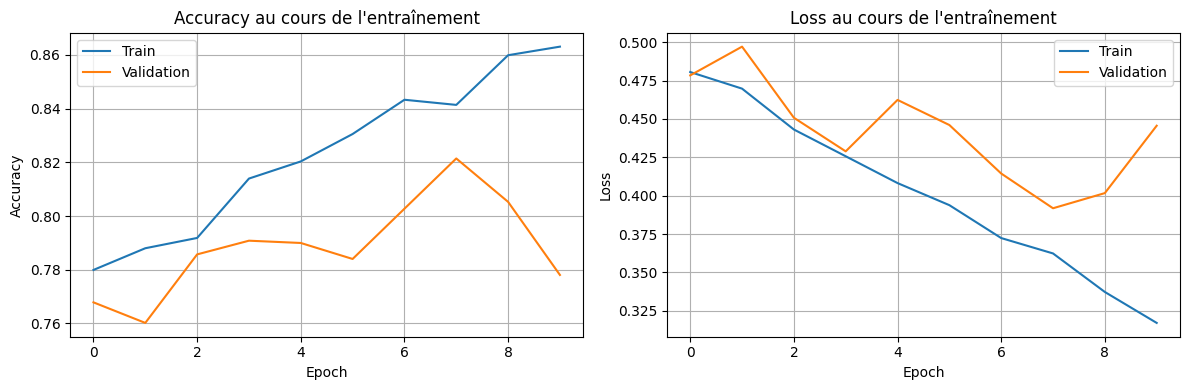

In [27]:
import matplotlib.pyplot as plt

# Tracer l'accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_naif_history.history['accuracy'], label='Train')
plt.plot(cnn_naif_history.history['val_accuracy'], label='Validation')
plt.title('Accuracy au cours de l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Tracer la loss
plt.subplot(1, 2, 2)
plt.plot(cnn_naif_history.history['loss'], label='Train')
plt.plot(cnn_naif_history.history['val_loss'], label='Validation')
plt.title('Loss au cours de l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:

def plot_training_analysis(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def Analyse_resultats(cnn,cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(val_generator, verbose=1)

    t_prediction_cnn = time.time() - t_prediction_cnn

    print('Train accuracy:', score_cnn_train[1])
    print('Validation accuracy:', score_cnn_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction_cnn)

    plot_training_analysis(cnn_history)
    return t_prediction_cnn

236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8533 - loss: 0.3294
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7781 - loss: 0.4456
Train accuracy: 0.8532851338386536
Validation accuracy: 0.7780612111091614
Time Prediction: 17.44 seconds


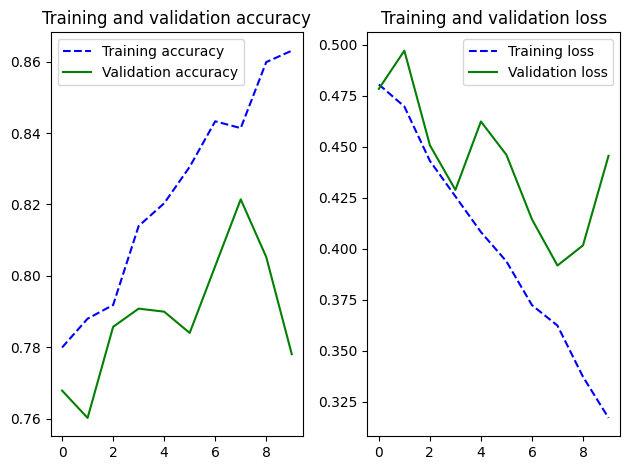

In [30]:
t_prediction_cnn_naif = Analyse_resultats(cnn_naif,cnn_naif_history)

In [31]:
test_steps = len(test_df) // batch_size
test_loss, test_accuracy = cnn_naif.evaluate(test_generator, steps=test_steps)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 25s 343ms/step - accuracy: 0.7959 - loss: 0.4430
Test Accuracy: 0.7959
Test Loss: 0.4430


73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step


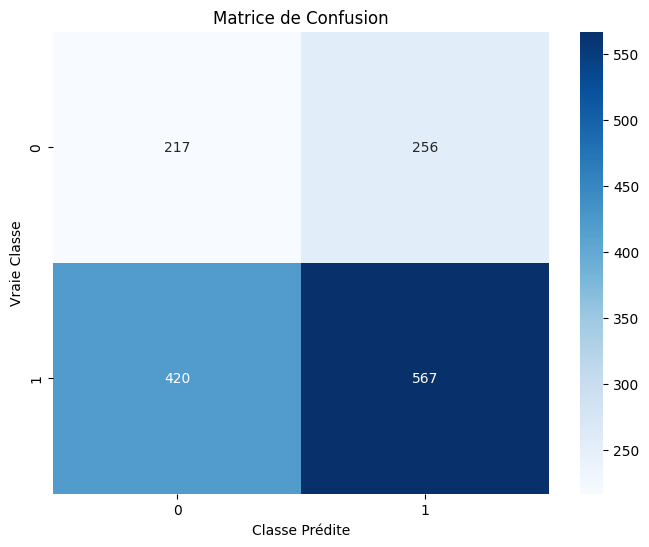

              precision    recall  f1-score   support

         Cat       0.34      0.46      0.39       473
         Dog       0.69      0.57      0.63       987

    accuracy                           0.54      1460
   macro avg       0.51      0.52      0.51      1460
weighted avg       0.58      0.54      0.55      1460



In [32]:
# Prédictions sur le test set
test_generator.reset()
predictions = cnn_naif.predict(test_generator, steps=test_steps)

# Convertir les probabilités en classes (0 ou 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Obtenir les vraies classes
true_classes = test_generator.classes[:len(predicted_classes)]

# Matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

# Rapport de classification
print(classification_report(true_classes, predicted_classes, 
                          target_names=['Cat', 'Dog']))

### Amélioration 

In [36]:

def plot_training_analysis(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def Analyse_resultats(cnn, cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(val_generator, verbose=1)
    t_prediction_cnn = time.time() - t_prediction_cnn
    
    print('Train accuracy:', score_cnn_train[1])  
    print('Validation accuracy:', score_cnn_validation[1]) 
    print("Time Prediction: %.2f seconds" % t_prediction_cnn) 
    
    plot_training_analysis(cnn_history) 
    return t_prediction_cnn 

### data augmentation

In [39]:
# Générateur avec Augmentation (Rotation, Zoom, Flip...)
aug_datagen = ImageDataGenerator(
    rotation_range = 10,
    rescale = 1./255,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range=[0.9,1.1], 
    channel_shift_range=10, 
    horizontal_flip = True,
    fill_mode='nearest'
)

# Seul le train est augmenté ! Val et Test restent "normaux"
train_gen_aug = aug_datagen.flow_from_dataframe(
    train_df, directory=img_dir, x_col='Image', y_col='SPECIES_NAME',
   target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary' 
)

# On réutilise le même modèle, mais entraîné sur des données augmentées
cnn_aug = cnn_simple("cnn_augmente")
history_aug, temps_aug = Entrainement(
    cnn_aug, 
    train_gen_aug,  
    epochs=30,  
    learn_rate=3e-4
)



Found 4703 validated image filenames belonging to 2 classes.
Entrainement de  cnn_augmente
Epoch 1/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.6766 - loss: 0.6213 - val_accuracy: 0.6777 - val_loss: 0.6353
Epoch 2/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - accuracy: 0.6781 - loss: 0.6062 - val_accuracy: 0.6794 - val_loss: 0.6827
Epoch 3/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.6845 - loss: 0.6031 - val_accuracy: 0.6828 - val_loss: 0.5918
Epoch 4/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.6828 - loss: 0.5914 - val_accuracy: 0.6913 - val_loss: 0.5711
Epoch 5/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 29s 122ms/step - accuracy: 0.6934 - loss: 0.5893 - val_accuracy: 0.7041 - val_loss: 0.5658
Epoch 6/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - accuracy: 0.6981 - loss: 0.5815 - val_accuracy: 0.7066 - val_loss: 0.5694
Epoch 7/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - accuracy: 0.7110 - loss: 0.5691 - val_accuracy: 0.7066 - val_loss:

236/236 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9035 - loss: 0.2290
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8724 - loss: 0.2917
Train accuracy: 0.9034658670425415
Validation accuracy: 0.8724489808082581
Time Prediction: 19.07 seconds


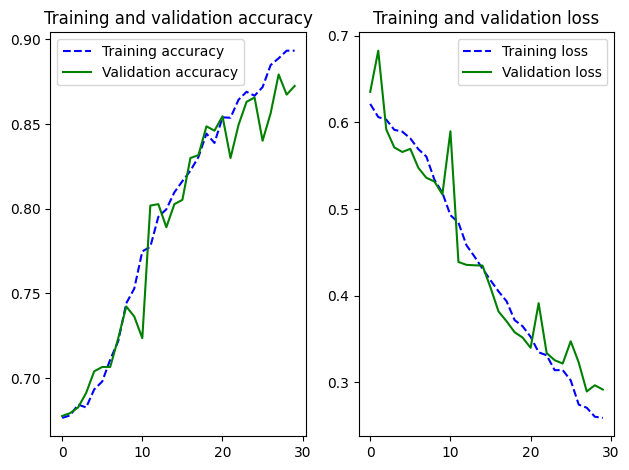

In [40]:
temps_prediction = Analyse_resultats(cnn_aug, history_aug)

pre trained network

Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 43s 158ms/step - accuracy: 0.8057 - loss: 0.4208 - val_accuracy: 0.8529 - val_loss: 0.3202
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.8595 - loss: 0.3181 - val_accuracy: 0.8886 - val_loss: 0.2628
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.8648 - loss: 0.2980 - val_accuracy: 0.8920 - val_loss: 0.2628
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.8788 - loss: 0.2772 - val_accuracy: 0.8988 - val_loss: 0.2370
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.8775 - loss: 0.2775 - val_accuracy: 0.8929 - val_loss: 0.2363
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.8807 - loss: 0.2710 - val_accuracy: 0.8980 - val_loss: 0.2434
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.8890 - loss: 0.2585 - val_accuracy: 0.9014 - val_loss: 0.2288
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.8848 - loss: 0

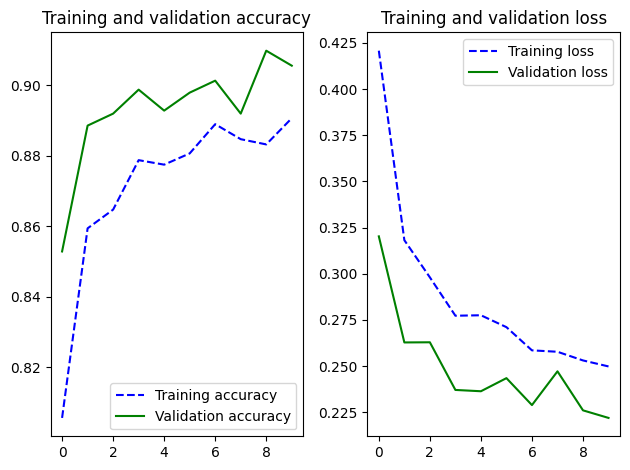

In [ ]:
#Chargement de VGG16 sans la partie classification (include_top=False)
base_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_width, img_height, 3)  
)
base_model.trainable = False  # IMPORTANT : On gèle les poids du VGG

# Ajout de notre tête de classification
inputs = Input(shape=(img_width, img_height, 3))  
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Plus efficace que Flatten
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  

model_transfer = Model(inputs, outputs, name="VGG16_Transfer")

# Compilation pour classification binaire
model_transfer.compile(
    optimizer=Adam(learning_rate=1e-3), 
    loss='binary_crossentropy',  
    metrics=['accuracy']
)

# Afficher l'architecture
model_transfer.summary()

# Entraînement (Rapide car on n'entraîne que les dernières couches)
history_transfer = model_transfer.fit(
    train_gen_aug,  
    validation_data=val_generator,  
    epochs=10
)

# Analyser les résultats
temps_prediction_transfer = Analyse_resultats(model_transfer, history_transfer)

OVERFITTING ?

fine tuning

### FINE TUNING SUR MODELE VGG 16 PRÉ ENTRAÎNÉ

In [43]:

vgg_combined_fine = clone_model(model_transfer)
vgg_combined_fine.set_weights(model_transfer.get_weights())


conv_base = next(layer for layer in vgg_combined_fine.layers if "vgg16" in layer.name.lower())
conv_base.trainable = True


for layer in conv_base.layers[:15]:
    layer.trainable = False

vgg_combined_fine.summary()

Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_337 (InputLayer)   │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,268,293 (111.65 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,422,020 (55.02 MB)

In [49]:
vgg_combined_history,t_learning_vgg_combined_augmented = Entrainement(vgg_combined_fine,train_gen_aug)

Entrainement de  VGG16_Transfer
Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.8203 - loss: 0.4228 - val_accuracy: 0.9218 - val_loss: 0.1959
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 31s 132ms/step - accuracy: 0.9137 - loss: 0.2111 - val_accuracy: 0.9218 - val_loss: 0.2019
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - accuracy: 0.9354 - loss: 0.1591 - val_accuracy: 0.9600 - val_loss: 0.1034
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 34s 146ms/step - accuracy: 0.9579 - loss: 0.1173 - val_accuracy: 0.9583 - val_loss: 0.1224
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.9585 - loss: 0.1082 - val_accuracy: 0.9558 - val_loss: 0.1158
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.9653 - loss: 0.0863 - val_accuracy: 0.9430 - val_loss: 0.1305
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - accuracy: 0.9751 - loss: 0.0732 - val_accuracy: 0.9532 - val_loss: 0.1146
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/s

236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.9940 - loss: 0.0144
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9583 - loss: 0.1294
Train accuracy: 0.9940463304519653
Validation accuracy: 0.9583333134651184
Time Prediction: 22.59 seconds


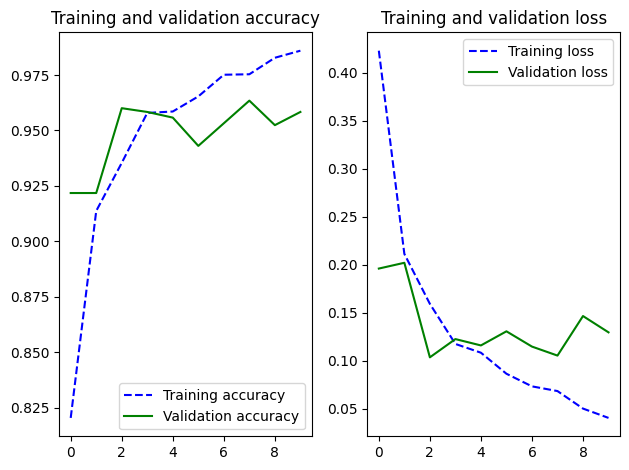

In [50]:
t_prediction_cnn_data_augmented = Analyse_resultats(vgg_combined_fine,vgg_combined_history)

on diminue le learning rate

In [51]:

vgg_combined_fine_plus = clone_model(vgg_combined_fine)
vgg_combined_fine_plus.set_weights(vgg_combined_fine.get_weights())

for layer in vgg_combined_fine_plus.layers:
    layer.trainable = True
    # Si une couche est un modèle (comme VGG16), il faut débloquer ses sous-couches aussi
    if hasattr(layer, "layers"):
        for sub_layer in layer.layers:
            sub_layer.trainable = True


vgg_combined_fine_plus.summary()

Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_337 (InputLayer)   │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,268,293 (111.65 MB)

 Trainable params: 14,846,273 (56.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,422,020 (55.02 MB)

In [52]:
vgg_combined_fine_plus_history,t_learning_vgg_combined_fine_plus = Entrainement(vgg_combined_fine_plus, train_gen_aug, epochs=4, learn_rate=1e-5)

Entrainement de  VGG16_Transfer
Epoch 1/4
236/236 ━━━━━━━━━━━━━━━━━━━━ 54s 166ms/step - accuracy: 0.9875 - loss: 0.0369 - val_accuracy: 0.9677 - val_loss: 0.1126
Epoch 2/4
236/236 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.9932 - loss: 0.0186 - val_accuracy: 0.9515 - val_loss: 0.1608
Epoch 3/4
236/236 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - accuracy: 0.9938 - loss: 0.0227 - val_accuracy: 0.9660 - val_loss: 0.1023
Epoch 4/4
236/236 ━━━━━━━━━━━━━━━━━━━━ 34s 142ms/step - accuracy: 0.9951 - loss: 0.0127 - val_accuracy: 0.9694 - val_loss: 0.1058
Learning time for 4 epochs : 153 seconds


236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.9974 - loss: 0.0069
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9694 - loss: 0.1058
Train accuracy: 0.9974484443664551
Validation accuracy: 0.9693877696990967
Time Prediction: 21.94 seconds


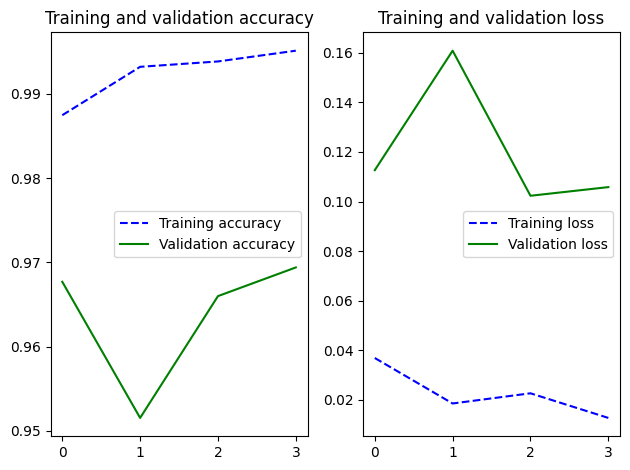

In [53]:
t_prediction_vgg_combined_fine_plus = Analyse_resultats(vgg_combined_fine_plus,vgg_combined_fine_plus_history)


precision au max => on va faire sur le test maintenant

74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step


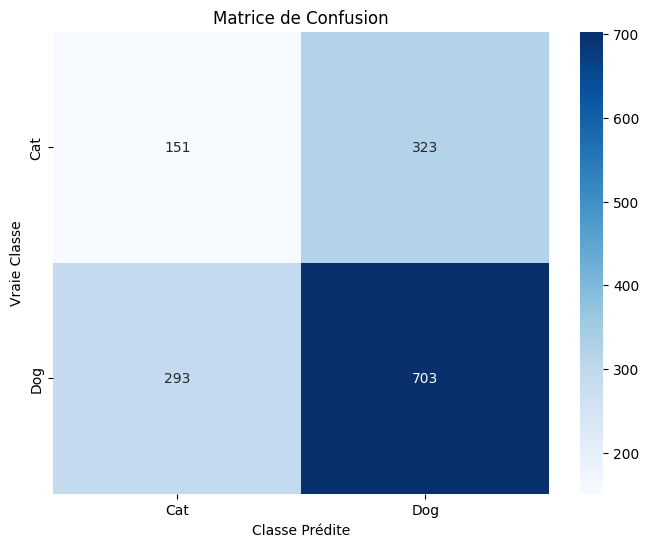


=== Rapport de Classification ===
              precision    recall  f1-score   support

         Cat       0.34      0.32      0.33       474
         Dog       0.69      0.71      0.70       996

    accuracy                           0.58      1470
   macro avg       0.51      0.51      0.51      1470
weighted avg       0.57      0.58      0.58      1470



In [55]:
test_generator.reset()
predictions = vgg_combined_fine_plus.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Vraies classes
true_classes = test_generator.classes

# Matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], 
            yticklabels=['Cat', 'Dog'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

# Rapport détaillé
print("\n=== Rapport de Classification ===")
print(classification_report(true_classes, predicted_classes, 
                          target_names=['Cat', 'Dog']))

74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step
Nombre d'erreurs : 652 / 1470


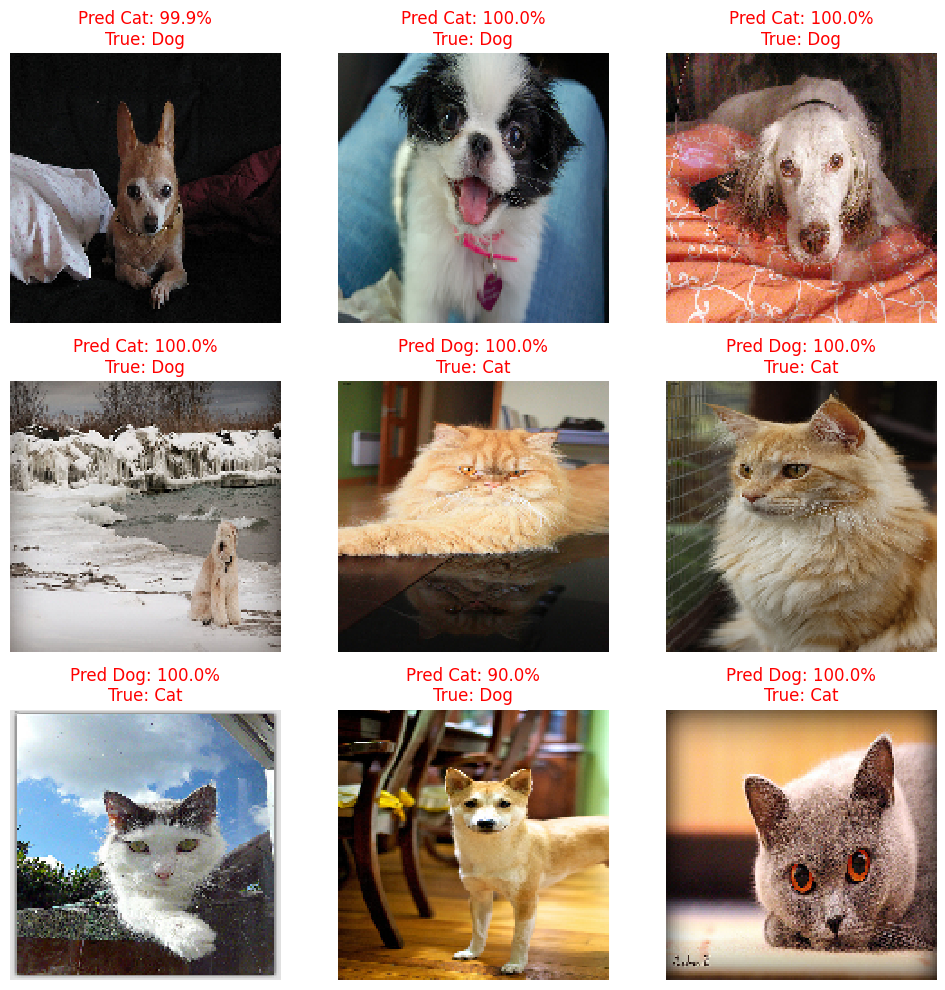

In [57]:
test_preds = vgg_combined_fine_plus.predict(test_generator)
y_true = test_generator.classes  # classes réelles
y_pred = (test_preds > 0.5).astype(int).flatten()  # prédictions binaires

# Identifier les erreurs
error_idx = np.where(y_true != y_pred)[0]
print(f"Nombre d'erreurs : {len(error_idx)} / {len(y_true)}")

# Visualiser quelques erreurs
n_errors_to_show = min(9, len(error_idx))
selected_errors = np.random.choice(error_idx, size=n_errors_to_show, replace=False)

fig = plt.figure(figsize=(10,10))

for i, idx in enumerate(selected_errors):
    # Charger l'image
    img = img_to_array(load_img(test_generator.filepaths[idx], target_size=(img_width, img_height)))/255
    
    pred_prob = test_preds[idx][0]
    
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img, interpolation='nearest')
    
    # Déterminer le titre et la couleur
    if pred_prob > 0.5:
        title = f"Pred Dog: {pred_prob*100:.1f}%\nTrue: {'Dog' if y_true[idx]==1 else 'Cat'}"
        color = "red" if y_true[idx]==0 else "green"
    else:
        title = f"Pred Cat: {(1-pred_prob)*100:.1f}%\nTrue: {'Cat' if y_true[idx]==0 else 'Dog'}"
        color = "red" if y_true[idx]==1 else "green"
    
    ax.set_title(title, color=color)
    ax.axis("off")

plt.tight_layout()
plt.show()


### Classification fine

In [61]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [62]:

# --- Paramètres ---
IMG_SIZE = (128, 128) # Réduit pour soulager le CPU/GPU
BATCH_SIZE = 32

# --- Générateurs (Data Augmentation vue en TP) ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Création du flux pour les RACES (Classification Fine) ---
# Pour Chats vs Chiens, changez juste y_col="SPECIES_NAME" et class_mode="binary"
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=img_dir,
    x_col="Image",
    y_col="BREED_NAME",      # Cible : Nom de la race
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical" # 37 classes
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=img_dir,
    x_col="Image",
    y_col="BREED_NAME",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# --- Modèle Transfer Learning (VGG16) ---
# Comme vu dans la section "Pre-trained Network" du TP
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # On gèle les poids

# Construction du classifier
x = base_model.output
x = GlobalAveragePooling2D()(x) # Ou Flatten() comme dans le TP simple
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(37, activation='softmax')(x) # 37 neurones pour les 37 races

model_clf = Model(inputs=base_model.input, outputs=predictions)

model_clf.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# model_clf.summary()
# history_clf = model_clf.fit(train_generator, validation_data=val_generator, epochs=10)

Found 4703 validated image filenames belonging to 37 classes.
Found 1176 validated image filenames belonging to 37 classes.


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step


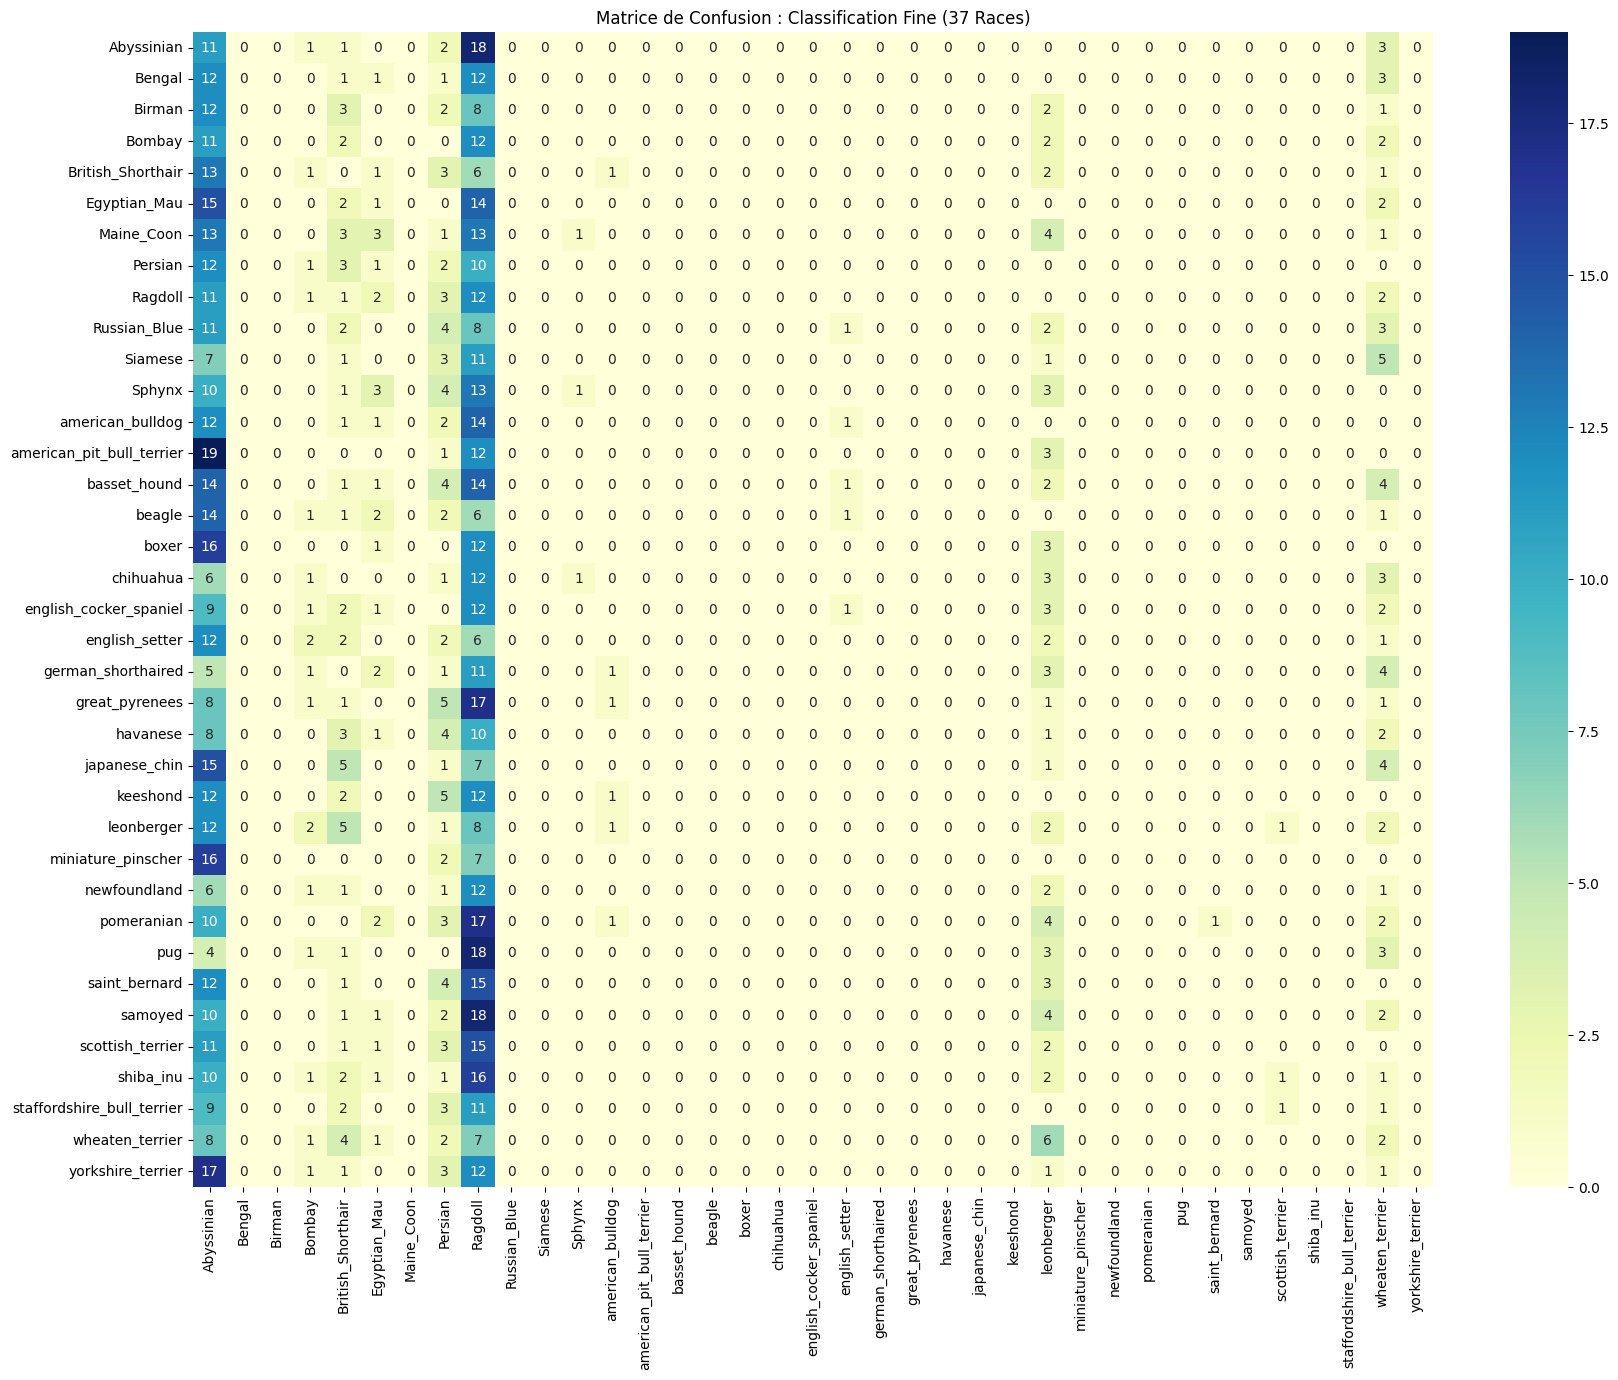

In [63]:
val_gen.reset()
preds = model_clf.predict(val_gen)
pred_classes = np.argmax(preds, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# 2. Créer la matrice
cm = confusion_matrix(true_classes, pred_classes)

# 3. Affichage large
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Matrice de Confusion : Classification Fine (37 Races)')
plt.show()

### data augmentation

In [66]:
aug_datagen_fine = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Un peu plus de rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Application sur le générateur de train
train_gen_fine = aug_datagen_fine.flow_from_dataframe(
    train_df,
    directory=img_dir,
    x_col='Image',
    y_col='BREED_NAME', 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4703 validated image filenames belonging to 37 classes.


In [67]:
# On gèle tout le backbone
base_model.trainable = False 

model_clf.compile(
    optimizer=Adam(learning_rate=1e-3), # Learning rate normal pour la tête
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraîner sur 5-10 époques
history_warmup = model_clf.fit(train_gen_fine, validation_data=val_gen, epochs=5)


Epoch 1/5


ValueError: Input 0 of layer "functional_41" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 150, 150, 3)

### Segmentation

In [ ]:

class PetSegmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mask_dir, batch_size=32, img_size=(128, 128)):
        self.df = df
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        masks = []
        
        for _, row in batch_df.iterrows():
            # 1. Charger l'image
            img_path = os.path.join(self.img_dir, row['Image'])
            img = load_img(img_path, target_size=self.img_size)
            img = img_to_array(img) / 255.0 # Normalisation
            
            # 2. Charger le masque
            mask_path = os.path.join(self.mask_dir, row['mask_filename'])
            # load_img en grayscale pour avoir (H, W) et pas (H, W, 3)
            mask = load_img(mask_path, target_size=self.img_size, color_mode="grayscale")
            mask = img_to_array(mask)
            
            # 3. Prétraitement du masque Oxford
            # Valeurs originales : 1 (Animal), 2 (Fond), 3 (Bordure)
            # On transforme en Binaire : 1 (Animal) vs 0 (Le reste)
            mask = np.where(mask == 1, 1.0, 0.0)
            
            images.append(img)
            masks.append(mask)
            
        return np.array(images), np.array(masks)

# Création des générateurs de segmentation
train_gen_seg = PetSegmentationGenerator(train_df, img_dir, mask_dir, BATCH_SIZE, IMG_SIZE)
val_gen_seg = PetSegmentationGenerator(val_df, img_dir, mask_dir, BATCH_SIZE, IMG_SIZE)

In [ ]:


def build_unet(input_shape):
    inputs = Input(input_shape)

    # --- Contraction (Encoder) ---
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # --- Bottleneck ---
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # --- Expansion (Decoder) ---
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = Concatenate()([u5, c3]) # Skip connection
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    # --- Sortie ---
    # Sigmoid car on fait une segmentation binaire (pixel = animal ou pas)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return Model(inputs=[inputs], outputs=[outputs])

unet_model = build_unet(IMG_SIZE + (3,))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# unet_model.summary()
# history_unet = unet_model.fit(train_gen_seg, validation_data=val_gen_seg, epochs=15)

### Pour aller plus loin

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_multitask_model(input_shape, num_classes):
    inputs = Input(input_shape, name='input_image')

    # --- 1. ENCODEUR PARTAGÉ (Shared Backbone) ---
    # On peut utiliser un VGG16 pré-entraîné ou faire le nôtre
    # Ici, un exemple simple "From Scratch" pour bien comprendre
    
    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x) # 64x64
    f1 = x # Skip connection pour la segmentation
    
    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x) # 32x32
    f2 = x 
    
    # Block 3 (Bottleneck partagé)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2))(x) # 16x16
    
    # --- 2. BRANCHE CLASSIFICATION (Tête 1) ---
    c = GlobalAveragePooling2D()(encoded) # Aplatit les features
    c = Dense(128, activation='relu')(c)
    c = Dropout(0.5)(c)
    # Sortie 1 : Classification (Nommé 'class_output')
    class_output = Dense(num_classes, activation='softmax', name='class_output')(c)

    # --- 3. BRANCHE SEGMENTATION (Tête 2 - Decoder) ---
    # On remonte la résolution comme dans un U-Net
    
    # Upsample 1
    s = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(encoded) # 32x32
    s = Concatenate()([s, f2]) # On récupère l'info spatiale de l'encodeur
    s = Conv2D(64, (3, 3), activation='relu', padding='same')(s)
    
    # Upsample 2
    s = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(s) # 64x64
    s = Concatenate()([s, f1])
    s = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    
    # Upsample 3 (Retour taille originale)
    s = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(s) # 128x128
    
    # Sortie 2 : Segmentation (Nommé 'seg_output')
    seg_output = Conv2D(1, (1, 1), activation='sigmoid', name='seg_output')(s)

    # --- MODÈLE FINAL ---
    model = Model(inputs=inputs, outputs=[class_output, seg_output])
    return model

# Création du modèle
model_joint = build_multitask_model((128, 128, 3), num_classes=37)
model_joint.summary()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, to_categorical

class MultiTaskGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mask_dir, batch_size, img_size, num_classes):
        self.df = df
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        
        # Création d'un mapping race -> int si ce n'est pas déjà fait
        self.breeds = sorted(df['BREED_NAME'].unique())
        self.breed_to_idx = {b: i for i, b in enumerate(self.breeds)}

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]
        
        images = []
        class_labels = []
        masks = []
        
        for _, row in batch_df.iterrows():
            # Image
            img = load_img(os.path.join(self.img_dir, row['Image']), target_size=self.img_size)
            images.append(img_to_array(img) / 255.0)
            
            # Label Classification (One-hot encoding)
            label_idx = self.breed_to_idx[row['BREED_NAME']]
            class_labels.append(label_idx)
            
            # Masque Segmentation
            mask_path = os.path.join(self.mask_dir, row['mask_filename'])
            mask = load_img(mask_path, target_size=self.img_size, color_mode="grayscale")
            mask = img_to_array(mask)
            mask = np.where(mask == 1, 1.0, 0.0) # Binarisation
            masks.append(mask)
            
        X = np.array(images)
        y_class = to_categorical(class_labels, num_classes=self.num_classes)
        y_seg = np.array(masks)
        
        # IMPORTANT : On renvoie un dictionnaire correspondant aux noms des couches de sortie
        return X, {'class_output': y_class, 'seg_output': y_seg}

# Instanciation
train_gen_multi = MultiTaskGenerator(train_df, img_dir, mask_dir, 32, (128, 128), 37)
val_gen_multi = MultiTaskGenerator(val_df, img_dir, mask_dir, 32, (128, 128), 37)

In [ ]:
# On définit une loss différente pour chaque sortie
losses = {
    'class_output': 'categorical_crossentropy',
    'seg_output': 'binary_crossentropy' # Ou une Dice Loss personnalisée
}

# On peut donner plus d'importance à l'une ou l'autre
loss_weights = {
    'class_output': 1.0,  # Poids de la classification
    'seg_output': 1.0     # Poids de la segmentation
}

model_joint.compile(
    optimizer='adam',
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        'class_output': 'accuracy', 
        'seg_output': 'accuracy' # Ou IoU
    }
)

# Entraînement
history = model_joint.fit(
    train_gen_multi,
    validation_data=val_gen_multi,
    epochs=15
)